In [1]:
import numpy as np
import pickle as pkl
from moviepy.editor import *
import matplotlib.pyplot as plt

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


# Environment definition

In [70]:
class Warehouse():
    
    def __init__(self, layout):
        self.layout = np.array(layout)
        
    def cross_out_pellet(self, x, y):
        self.layout[x,y] = 2
        
    def field_of_vision(self, x, y):
        x_min = x-1 if x >= 1 else 0
        y_min = y-1 if y >= 1 else 0
        x_max = x+1 if x <= self.layout.shape[0]-1 else self.layout.shape[0]-1
        y_max = y+1 if y <= self.layout.shape[1]-1 else self.layout.shape[1]-1
        return(self.layout[x_min:x_max, y_min:y_max])

In [71]:
test_warehouse = Warehouse(
    [[0,1,1,1,0], [1,0,0,0,1], [1,0,0,0,1], [1,0,0,0,1], [1,0,0,0,1]]
)

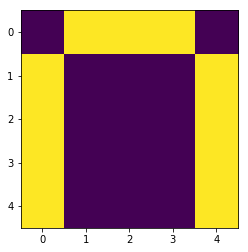

In [72]:
plt.imshow(test_warehouse.layout)

# Agents definition

## Drone

In [34]:
def add_to_path(func):
    def wrapper(*args, **kwargs):
        func(*args, **kwargs)
        args[0].path.append((args[0].state, args[0].z))
    return(wrapper)


class Drone():
    
    def __init__(self, charge_costs, state="start", step=2, max_z=12, charge=100):
        self.z = 0
        self.state = state
        self.step = step
        self.max_z = max_z
        self.charge = charge
        self.charge_costs = charge_costs
        self.path = []
        self.scanned_pellets = []
        
    @add_to_path
    def start(self, pellet_coordinates):
        self.z = 0
        self.state = "start"
        self.scanned_pellets.append(pellet_coordinates)
        
    @add_to_path
    def start(self):
        self.z = 0
        self.state = "charging"
        
    @add_to_path
    def up(self):
        self.z += self.step
        self.state = "ascending"
        
    @add_to_path
    def down(self):
        self.z -= self.step
        self.state = "descending"
        
    @add_to_path
    def scan(self):
        self.state = "scanning"
        
    @add_to_path
    def wait(self):
        self.state = "awaiting"
        
    def action(self):
        if self.charge > 0:
            if self.state == "start":
                self.up()
            elif self.state == "ascending":
                if self.z < self.max_z:
                    self.scan()
                else:
                    self.scan()
                    self.down()
            elif self.state == "scanning":
                self.up()
            elif self.state == "descending":
                if self.z > 0:
                    self.down()
                else:
                    self.wait()
            self.charge -= self.charge_costs[self.state]
        else:
            while self.z > 0:
                self.down()
            self.z = 0
            self.state = "charging"

In [39]:
test_costs = {
    "start": 0,
    "scanning": 1,
    "ascending": 1,
    "descending": 1,
    "awaiting": 0,
    "charging": -100
}

In [36]:
d = Drone(test_costs)

In [37]:
while d.state != "awaiting":
    d.action()
    print(d.state, d.z)

ascending 2
scanning 2
ascending 4
scanning 4
ascending 6
scanning 6
ascending 8
scanning 8
ascending 10
scanning 10
ascending 12
descending 10
descending 8
descending 6
descending 4
descending 2
descending 0
awaiting 0


## Mobile platform

In [ ]:
class MobilePlatform(Drone):
    
    def __init__(self, charge_costs, drones, state="start", step=1, start_z=(0,0), charge=100):
        self.z = start_z
        self.state = state
        self.step = step
        self.charge = charge
        self.charge_costs = charge_costs
        self.path = []
        self.field_of_vision = []
        self.drones = drones
        
    def launch_drone(self, drone_number, pellet_coordinates):
        self.drones[drone_number].start(pellet_coordinates)
        while self.drones[drone_number].state != "awaiting":
            self.drones[drone_number].action()
    

In [39]:
test_costs = {
    "start": 0,
    "moving": 1,
    "awaiting": 0,
    "charging": -100,
    
}